In [1]:
# load libs
import torch
import argparse
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from data.datasets import MNIST
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
'''
@ Original 28x28 is rescaled to 32x32 to meet 2^P size
@ batch_size and workders can be increased for faster loading
'''
print torch.__version__
batch_size=1
test_batch_size=1
kwargs={}
train_loader=data_utils.DataLoader(MNIST(root='./data',train=True,process=False,transform=transforms.Compose([
    transforms.Scale((32,32)),
    transforms.ToTensor(),
])),batch_size=batch_size,shuffle=True,**kwargs)


test_loader=data_utils.DataLoader(MNIST(root='./data',train=False,process=False,transform=transforms.Compose([
    transforms.Scale((32,32)),
    transforms.ToTensor(),
])),batch_size=test_batch_size,shuffle=True,**kwargs)

0.2.0_4


In [3]:
'''
@ For demo use, only use first 1000 samples
'''
def create_numpy_dataset():
    datasets = []
    for data in train_loader:
        data_numpy = data[0].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)

    datasets = np.array(datasets)
    datasets=np.expand_dims(datasets,axis=1)
    return datasets[:100]

In [4]:
'''
@ depth: determine shape, initial: 0
'''
from itertools import product
def fit_pca_shape(datasets,depth):
    factor=np.power(2,depth)
    length=32/factor
    idx1=range(0,length,2)
    idx2=[i+2 for i in idx1]
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print 'fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape)

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],2,2))
    print 'fit_pca_shape: reshape: {}'.format(data.shape)
    return data

In [5]:
'''
@ Prepare shape changes. 
@ return filters for convolution
@ aug_anchors: [out_num*in_num,4] -> [out_num,in_num,2,2]
'''
def ret_filt_patches(aug_anchors,input_channels):
    shape=aug_anchors.shape[1]/4
    num=aug_anchors.shape[0]
    filt=np.reshape(aug_anchors,(num,shape,4))
    
    # reshape to kernels, (# output_channels,# input_channels,2,2)
    filters=np.reshape(filt,(num,shape,2,2))

    return filters

In [6]:
'''
@ return: augmented anchors
'''
def PCA_and_augment(data_in):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    mean=np.mean(data,axis=0)
    datas_mean_remov = data - mean

    pca=PCA()
    datas_mean_remov.astype(np.float64)
    pca.fit(datas_mean_remov)
    comps=pca.components_

    if comps[-1][0]<0:
        for i in comps:
            i*=-1
    comps_aug=[vec*(-1) for vec in comps]
    comps_complete=np.vstack((comps,comps_aug))
    
    return comps_complete,mean

In [7]:
'''
@ input: kernel and data
@ output: conv+relu result
'''
def conv_and_relu(filters,datasets,stride=2):
    # torch data change
    
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)

    # Relu
    relu_output=F.relu(output)

    return relu_output,filt

In [8]:
'''
@ One-stage Saak transform
@ input: datasets [60000,channel,size,size]
'''
def one_stage_saak_trans(datasets=None,depth=0):

    print 'one_stage_saak_trans: datasets.shape {}'.format(datasets.shape)
    input_channels=datasets.shape[1]

    data_flatten=fit_pca_shape(datasets,depth)
    
    comps_complete,mean=PCA_and_augment(data_flatten)

    filters=ret_filt_patches(comps_complete,input_channels)
    print 'one_stage_saak_trans: filters: {}'.format(filters.shape)

    mean=np.mean(datasets,axis=0)
    datasets-=mean
    relu_output,filt=conv_and_relu(filters,datasets,stride=2)
    res=relu_output.data.numpy()
    
    print 'one_stage_saak_trans final.shape: {}'.format(res.shape)

    return res,filt,Variable(torch.from_numpy(res)),mean


In [9]:
'''
@ Multi-stage Saak transform
'''
def multi_stage_saak_trans():
    filters = []
    outputs = []
    means=[]
    data=create_numpy_dataset()
    dataset=np.copy(data)
    num=0
    img_len=data.shape[-1]
    while(img_len>=2):
        num+=1
        img_len/=2

    for i in range(num):
        print '{} stage of saak transform: '.format(i+1)
        data,filt,output,mean=one_stage_saak_trans(data,depth=i)
        filters.append(filt)
        outputs.append(output)
        means.append(mean)
        print ''

    return dataset,filters,outputs,means

In [10]:
datas,filters,outputs,means=multi_stage_saak_trans()

1 stage of saak transform: 
one_stage_saak_trans: datasets.shape (100, 1, 32, 32)
fit_pca_shape: data_lattice.shape: (256, 100, 1, 2, 2)
fit_pca_shape: reshape: (25600, 1, 2, 2)
one_stage_saak_trans: filters: (8, 1, 2, 2)
one_stage_saak_trans final.shape: (100, 8, 16, 16)

2 stage of saak transform: 
one_stage_saak_trans: datasets.shape (100, 8, 16, 16)
fit_pca_shape: data_lattice.shape: (64, 100, 8, 2, 2)
fit_pca_shape: reshape: (6400, 8, 2, 2)
one_stage_saak_trans: filters: (64, 8, 2, 2)
one_stage_saak_trans final.shape: (100, 64, 8, 8)

3 stage of saak transform: 
one_stage_saak_trans: datasets.shape (100, 64, 8, 8)
fit_pca_shape: data_lattice.shape: (16, 100, 64, 2, 2)
fit_pca_shape: reshape: (1600, 64, 2, 2)
one_stage_saak_trans: filters: (512, 64, 2, 2)
one_stage_saak_trans final.shape: (100, 512, 4, 4)

4 stage of saak transform: 
one_stage_saak_trans: datasets.shape (100, 512, 4, 4)
fit_pca_shape: data_lattice.shape: (4, 100, 512, 2, 2)
fit_pca_shape: reshape: (400, 512, 2, 2)


In [11]:
# show sample
def show_sample(ori,rec):
    plt.subplot(1,2,1)
    plt.imshow(ori)
    plt.subplot(1,2,2)
    plt.imshow(rec)
    plt.show()

In [12]:
import numpy as np

def psnr(im1,im2):
    diff =(im1 - im2)
    diff=diff**2
    rmse=np.sqrt(np.mean(diff.sum()))
    psnr = 20*np.log10(1/rmse)
    return psnr

In [13]:
'''
@ Reconstruct from second-last stage
@ In fact, can be from any stage
'''
def toy_recon(outputs,filters,means):
    outputs=outputs[::-1][2:]
    filters=filters[::-1][2:]
    means=means[::-1][2:]
    num=len(outputs)
    data=outputs[0]
    for i in range(num):
        data = F.conv_transpose2d(data, filters[i], stride=2)
        data+=Variable(torch.from_numpy(means[i]))
    return data

In [14]:
ret=toy_recon(outputs,filters,means)

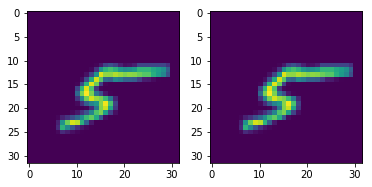

psnr metric: 104.494497321


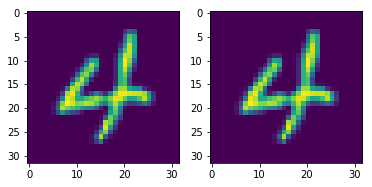

psnr metric: 104.943625755


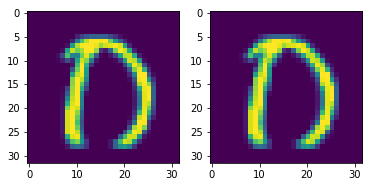

psnr metric: 101.114823042


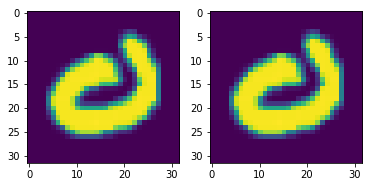

psnr metric: 98.7023309399


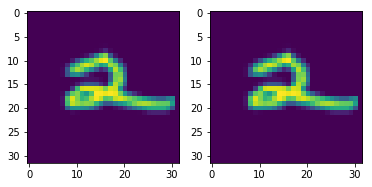

psnr metric: 104.162969609


In [15]:
for i in range(5): 
    inv_img=ret.data.numpy()[i][0]
    show_sample(datas[i][0],inv_img)
    print 'psnr metric: {}'.format(psnr(datas[i][0],inv_img))